# Isolated data loaders

In [1]:
import sys
from data_functions import *

/opt/conda/envs/mlenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!ls ../data/fires/fire_camp/S2/

2018-10-17.tif	2018-10-22.tif	2018-10-27.tif	2018-11-06.tif	2018-12-06.tif


In [3]:
# import omegaconf
# settings = omegaconf.OmegaConf.load("../starcop/configs/config.yaml")
# print(settings)

In [4]:
settings = {'dataloader': {'batch_size': 32, 'num_workers': 4}, 
            'dataset': {
                'data_base_path': '../data/fires/fire_camp/S2/', 
                'tile_px_size': 32,
                'tile_overlap_px': 0,
                'include_last_row_colum_extra_tile': False,
             }
           }
print(settings)

{'dataloader': {'batch_size': 32, 'num_workers': 4}, 'dataset': {'data_base_path': '../data/fires/fire_camp/S2/', 'tile_px_size': 32, 'tile_overlap_px': 0, 'include_last_row_colum_extra_tile': False}}


In [5]:
tiles = load_all_tile_indices_from_folder(settings["dataset"])

0 ../data/fires/fire_camp/S2/2018-10-17.tif loaded 1725 tiles.
1 ../data/fires/fire_camp/S2/2018-10-22.tif loaded 1725 tiles.
2 ../data/fires/fire_camp/S2/2018-10-27.tif loaded 1725 tiles.
3 ../data/fires/fire_camp/S2/2018-11-06.tif loaded 1725 tiles.
4 ../data/fires/fire_camp/S2/2018-12-06.tif loaded 1725 tiles.
Loaded: 8625 total tile indices


In [6]:
x = load_tile_idx(tiles[5], settings["dataset"])
print(x.shape,)

(15, 32, 32)


In [7]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

tiles_train, tiles_rest = train_test_split(tiles, test_size=1 - train_ratio)
tiles_val, tiles_test = train_test_split(tiles_rest, test_size=test_ratio/(test_ratio + validation_ratio)) 

print("train, test, val:",len(tiles_train), len(tiles_test), len(tiles_val))

training_data = TileDataset(tiles_train, settings["dataset"])
test_data = TileDataset(tiles_test, settings["dataset"])
val_data = TileDataset(tiles_val, settings["dataset"])

train_dataloader = DataLoader(training_data, batch_size=settings["dataloader"]["batch_size"], shuffle=True, num_workers=settings["dataloader"]["num_workers"])
test_dataloader = DataLoader(test_data, batch_size=settings["dataloader"]["batch_size"], shuffle=True, num_workers=settings["dataloader"]["num_workers"])
val_dataloader = DataLoader(val_data, batch_size=settings["dataloader"]["batch_size"], shuffle=True, num_workers=settings["dataloader"]["num_workers"])

print("made the dataloader")

train, test, val: 6900 863 862
made the dataloader


Feature batch shape: torch.Size([32, 15, 32, 32])
img shape: (32, 32, 3)


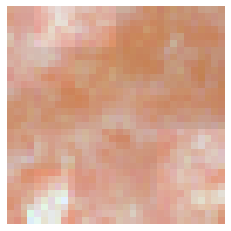

In [21]:
from pylab import plt
# Display image and label.
train_features = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")

img_all_bands = train_features[0]
img = img_all_bands[0:3,:,:]

img = np.moveaxis(img.numpy(), 0, -1)
print(f"img shape: {img.shape}")

figure = plt.figure()
plt.axis("off")
plt.imshow(np.clip(img / np.max(img),0,1))

plt.show()

# Full data module

In [1]:
import sys
from data_functions import *

settings = {'dataloader': {
                'batch_size': 100, 
                'num_workers': 4,
                'train_ratio': 0.80,
                'validation_ratio': 0.10,
                'test_ratio': 0.10,
            },
            'dataset': {
                'data_base_path': '../data/fires/fire_camp/S2/', 
                'tile_px_size': 32,
                'tile_overlap_px': 0,
                'include_last_row_colum_extra_tile': False,
                # 'normalization_precalculated_file': "",
                'normalization_precalculated_file': "S2L1C_v0_normalization_parameters.csv",
             },
            # 'normalizer': DataNormalizerLogManual,
            'normalizer': DataNormalizerMinMax,
           }
print(settings)

/opt/conda/envs/mlenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'dataloader': {'batch_size': 100, 'num_workers': 4, 'train_ratio': 0.8, 'validation_ratio': 0.1, 'test_ratio': 0.1}, 'dataset': {'data_base_path': '../data/fires/fire_camp/S2/', 'tile_px_size': 32, 'tile_overlap_px': 0, 'include_last_row_colum_extra_tile': False, 'normalization_precalculated_file': 'S2L1C_v0_normalization_parameters.csv'}, 'normalizer': <class 'data_functions.DataNormalizerMinMax'>}


In [2]:
data_normalizer = settings["normalizer"](settings)
print("loaded data_normalizer")

data_module = DataModule(settings, data_normalizer)
data_module.setup()
data_normalizer.setup(data_module)


loaded data_normalizer
0 ../data/fires/fire_camp/S2/2018-10-17.tif loaded 1725 tiles.
1 ../data/fires/fire_camp/S2/2018-10-22.tif loaded 1725 tiles.
2 ../data/fires/fire_camp/S2/2018-10-27.tif loaded 1725 tiles.
3 ../data/fires/fire_camp/S2/2018-11-06.tif loaded 1725 tiles.
4 ../data/fires/fire_camp/S2/2018-12-06.tif loaded 1725 tiles.
Loaded: 8625 total tile indices
Altogether we have 8625 tiles.
train, test, val: 6900 863 862


In [3]:
data_module.debug()

Dataset debug:
train 6900  tiles
val 862  tiles
test 863  tiles
Sample data:
x shapes: torch.Size([15, 32, 32])
debug for normalizer (DataNormalizerMinMax)
[x]
before 0.5704918 0.7934426 0.70112705
was normalized, will denormalize and go back
denormalized 1214.0 1282.0 1253.8438
normalized again 0.5704918 0.7934426 0.70112705

x shapes: torch.Size([15, 32, 32])
debug for normalizer (DataNormalizerMinMax)
[x]
before 0.47540984 1.252459 0.7306864
was normalized, will denormalize and go back
denormalized 1185.0 1422.0 1262.8594
normalized again 0.47540984 1.252459 0.7306864

x shapes: torch.Size([15, 32, 32])
debug for normalizer (DataNormalizerMinMax)
[x]
before 0.8819672 1.1672131 1.0016136
was normalized, will denormalize and go back
denormalized 1309.0 1396.0 1345.4922
normalized again 0.8819672 1.1672131 1.0016136

x shapes: torch.Size([15, 32, 32])
debug for normalizer (DataNormalizerMinMax)
[x]
before 0.009836066 0.2852459 0.14364755
was normalized, will denormalize and go back
den

## for normalization fitting ...

In [13]:
train_dataloader = data_module.train_dataloader()

all_data = []
for x in train_dataloader:
    print("loaded", x.shape)
    
    all_data = np.vstack([all_data, x]) if len(all_data) else x
    # print("all_data", all_data.shape)

    if len(all_data) > 1000:
        break

data_normalizer.estimate_from_data(x.numpy())
normalization_parameters = data_normalizer.normalization_parameters

loaded torch.Size([100, 15, 32, 32])
all_data torch.Size([100, 15, 32, 32])
loaded torch.Size([100, 15, 32, 32])
all_data (200, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (300, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (400, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (500, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (600, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (700, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (800, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (900, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (1000, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (1100, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (1200, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (1300, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (1400, 15, 32, 32)
loaded torch.Size([100, 15, 32, 32])
all_data (1500, 15, 32, 32)
loaded torch.Size([100

In [14]:
data_normalizer.save_normalization_parameters("S2L1C_v0_normalization_parameters.csv")